In [1]:
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_homecage = pd.read_csv('HomecageKmeansMeanClusters/Clustersk_120_2_homecage.csv')
df_overlapping = pd.read_csv('OverlappingKmeansMeanClusters/Clustersk_120_2_overlapping.csv')
df_random = pd.read_csv('RandomKmeansMeanClusters/Clustersk_120_2_random.csv')
df_stable = pd.read_csv('StableKmeansMeanClusters/Clustersk_120_2_stable.csv')

df_homecage_h = pd.read_csv('HomecageHMMMeanClusters/Clustershmm_120_2.csv')
df_overlapping_h = pd.read_csv('OverlappingHMMMeanClusters/Clustershmm_120_2_overlapping.csv')
df_stable_h = pd.read_csv('StableHMMMeanClusters/Clustershmm_120_2_stable.csv')
df_random_h = pd.read_csv('RandomHMMMeanClusters/Clustershmm_120_2_random.csv')

In [3]:
df_stats=pd.DataFrame(columns = ['Function','Mann-Whitney U1','Mann-Whitney P', 'Mean-HMM', 'Mean-KMeans'])

In [4]:
def whitney(x,y):
#     print(x,y)
    return mannwhitneyu(x, y, nan_policy='omit')

In [5]:
def t_test(x,y):
    return ttest_ind(x,y)

/tmp/ipykernel_4714/3040609530.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats=df_stats.append({'Function': column[i], 'Mann-Whitney U1': res[0],'Mann-Whitney P': res[1], 'Mean-HMM':mean_h, 'Mean-KMeans':mean }, ignore_index=True)
/tmp/ipykernel_4714/3040609530.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats=df_stats.append({'Function': column[i], 'Mann-Whitney U1': res[0],'Mann-Whitney P': res[1], 'Mean-HMM':mean_h, 'Mean-KMeans':mean }, ignore_index=True)
/tmp/ipykernel_4714/3040609530.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats=df_stats.append({'Function': column[i], 'Mann-Whitney U1': res[0],'Mann-Whitney P': res[1], 'Mean-HMM':mean_h, 'Mean-KMeans':mean }, ignore_index=True

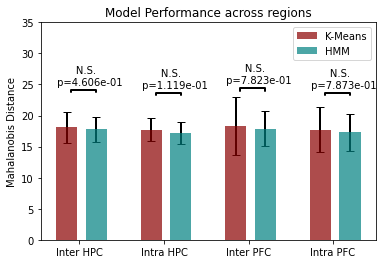

,Function,Mann-Whitney U1,Mann-Whitney P,Mean-HMM,Mean-KMeans
0,MahalanobisDistance_HPC_Inter_cluster,1466.0,0.460585,17.78149,18.139942
1,MahalanobisDistance_HPC_Intra_Cluster,1597.0,0.111939,17.207834,17.711504
2,MahalanobisDistance_PFC_Inter_cluster,1309.0,0.782317,17.889264,18.374007
3,MahalanobisDistance_PFC_Intra_Cluster,1394.0,0.787315,17.31025,17.705298


In [9]:
# Retrieve condition, kmeans values and hmm values

df_0=pd.concat([df_homecage,df_overlapping,df_random,df_stable])
df_1=pd.concat([df_homecage_h,df_overlapping_h,df_random_h,df_stable_h])

column=['MahalanobisDistance_HPC_Inter_cluster', 'MahalanobisDistance_HPC_Intra_Cluster',\
         'MahalanobisDistance_PFC_Inter_cluster', 'MahalanobisDistance_PFC_Intra_Cluster']
#         'PearsonDistance_HPC_Inter_cluster', 'PearsonDistance_HPC_Intra_Cluster',\
#          'PearsonDistance_PFC_Inter_cluster', 'PearsonDistance_PFC_Intra_Cluster']

menMeans=[]
menStd= []
menMeansh=[]
menStdh= []
w=[]
for i in range(4):
    # Retrieve means, standard deviation and similarity score
    res= whitney(df_0[column[i]].array, df_1[column[i]].array)
    hmm_mean_hpc_inter = df_1[column[i]].mean()
    mean = df_0[column[i]].mean()
    std=df_0[column[i]].std()
    mean_h = df_1[column[i]].mean()
    std_h=df_1[column[i]].std()
    
    menMeans.append(mean)
    menMeansh.append(mean_h)
    menStd.append(std)
    menStdh.append(std_h)
    w.append(res[1])
    # Add data to dataframe
    df_stats=df_stats.append({'Function': column[i], 'Mann-Whitney U1': res[0],'Mann-Whitney P': res[1], 'Mean-HMM':mean_h, 'Mean-KMeans':mean }, ignore_index=True)

# Plot data (adjust accordingly)
ind  = np.arange(4)    # the x locations for the groups
width= 0.5
labels = ('Inter HPC', 'Intra HPC', 'Inter PFC', 'Intra PFC')

bar_kwargs = {'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k'}  #for matplotlib >= v1.4 use 'fmt':'none' instead

fig, ax = plt.subplots()
ax.p1 = plt.bar(ind-0.7/2,menMeans, width =width/2, color='darkred', alpha=0.7, label= 'K-Means', **bar_kwargs)
ax.p2 = plt.bar(ind, menMeansh, width =width/2, color='teal',label='HMM',alpha=0.7, **bar_kwargs)

ax.errs = plt.errorbar(ind-0.7/2, menMeans, yerr=menStd,**err_kwargs,capsize=4)
ax.errs2 = plt.errorbar(ind, menMeansh, yerr=menStdh,**err_kwargs,capsize=4)

# Custom function to draw the diff bars
def precision_round(number, digits=3):
    return '{:0.3e}'.format(number)

def label_diff(i,j,text,X,Y, off=0, up=0, offnum=0, sett=0):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':5,'shrinkB':5,'linewidth':2}
    ax.annotate(text, xy=(X[i]-offnum,y+5+up), zorder=10)
    ax.annotate('', xy=(X[i]-off,y+3), xytext=(X[j]-sett,y+3), arrowprops=props)

# Call the function
label_diff(0,1,'       N.S.\n p=%s'%precision_round(w[0]),[ind[0]-0.3, ind[0]],[menMeans[0], menMeansh[0]], offnum=0.2)
label_diff(0,1,'       N.S.\n p=%s'%precision_round(w[1]),[ind[1]-0.3, ind[1]],[menMeans[1], menMeansh[1]], offnum=0.2)
label_diff(0,1,'       N.S.\n p=%s'%precision_round(w[2]),[ind[2]-0.3, ind[2]],[menMeans[2], menMeansh[2]], offnum=0.2)
label_diff(0,1,'       N.S.\n p=%s'%precision_round(w[3]),[ind[3]-0.3, ind[3]],[menMeans[3], menMeansh[3]], offnum=0.2)


plt.ylim(ymax=35)
plt.xticks(ind-0.2, labels, color='k')
ylabel('Mahalanobis Distance')
legend()
title('Model Performance across regions')
savefig('Model Comaparison')
show()

df_stats

In [17]:
df_stats.to_csv('Stats_hmm_k.csv')